In [1]:
# 禁用GPU（仅个人情况）
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np 

# 前处理 

## 数据增强器

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen_train = ImageDataGenerator(rotation_range=15,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          zoom_range=0.2,
                          rescale=1./255.0)


datagen_test = ImageDataGenerator(rescale=1./255.0)

# 加载数据

In [5]:
image_generator_train = datagen_train.flow_from_directory('brain_2d_seg_data/training',
                                                    target_size=(160,160),
                                                    classes=['images'],
                                                    class_mode=None,  # this just loads the images
                                                    seed=1, # fix the random seed
                                                    color_mode='grayscale',
                                                    batch_size=1)

mask1_generator_train = datagen_train.flow_from_directory('brain_2d_seg_data/training',
                                                  target_size=(160,160),
                                                  classes=['brain_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)


mask2_generator_train = datagen_train.flow_from_directory('brain_2d_seg_data/training',
                                                  target_size=(160,160),
                                                  classes=['ventricle_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)


image_generator_test = datagen_test.flow_from_directory('brain_2d_seg_data/test',
                                                    target_size=(160,160),
                                                    classes=['images'],
                                                    class_mode=None,
                                                    seed=1,
                                                    color_mode='grayscale',
                                                    batch_size=1)

mask1_generator_test = datagen_test.flow_from_directory('brain_2d_seg_data/test',
                                                  target_size=(160,160),
                                                  classes=['brain_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)

mask2_generator_test = datagen_test.flow_from_directory('brain_2d_seg_data/test',
                                                  target_size=(160,160),
                                                  classes=['ventricle_masks'],
                                                  class_mode=None,
                                                  seed=1,
                                                  color_mode='grayscale',
                                                  batch_size=1)

Found 915 images belonging to 1 classes.
Found 915 images belonging to 1 classes.
Found 915 images belonging to 1 classes.
Found 197 images belonging to 1 classes.
Found 197 images belonging to 1 classes.
Found 197 images belonging to 1 classes.


### 看看加载的图片

用  `next()` 获取图片

In [6]:
#get next batch
image_batch = image_generator_train.next()
mask1_batch = mask1_generator_train.next()
mask2_batch = mask2_generator_train.next()

#examine the output
print(image_batch.shape)


(1, 160, 160, 1)


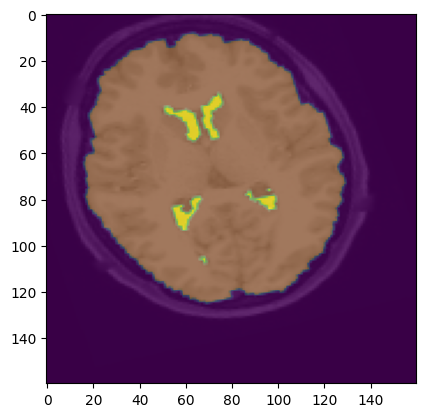

In [7]:
#plot image with mask overlaid
plt.figure()
plt.imshow(image_batch[0,:,:,0],cmap='gray')
plt.imshow(mask1_batch[0,:,:,0],alpha=0.7) # transparent
plt.imshow(mask2_batch[0,:,:,0],alpha=0.5) # transparent

### Use the Dice metric to evaluate performance 想想三类怎么写

In [8]:
from keras import backend as K

def dice_metric(y_true, y_pred):
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K.sum(y_true_f * y_pred_f)
     score = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

     return score

def dice_loss(y_true, y_pred):
    return (1 - dice_metric(y_true, y_pred))



In [9]:
"""
其他别人封装好的库 eg.

import segmentation_models as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(n_classes)) 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
"""

'\n其他别人封装好的库 eg.\n\nimport segmentation_models as sm\ndice_loss = sm.losses.DiceLoss(class_weights=np.ones(n_classes)) \nmetrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]\n'

## Create our model 

Use:
- Max-pooling & up-convolutions
- 16 deep in first conv layer
- 2 convolutions in each stage
- 4 skip connections
- padding to get same size outputs


Set each layer to `x`, to make it easier to copy-paste and re-arrange things. 



In [10]:
img_shape = (160,160,1)
input_layer = keras.layers.Input(img_shape)

x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(input_layer)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
out_layer1 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
out_layer2 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
out_layer3 = x
x = keras.layers.MaxPooling2D((2,2))(x)


x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
out_layer4 = x
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(256,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(128,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer4,x])
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(128,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(64,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer3,x])
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(64,(3,3), padding='same',activation='relu')(x)


x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(32,(2,2), padding='same',activation='relu')(x)


x = keras.layers.Concatenate(axis=3)([out_layer2,x])   # axis specifies along which axis the input will be concatenated
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(32,(3,3), padding='same',activation='relu')(x)

x = keras.layers.UpSampling2D((2,2))(x)
x = keras.layers.Conv2D(16,(2,2), padding='same',activation='relu')(x)

x = keras.layers.Concatenate(axis=3)([out_layer1,x])
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
x = keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)

#1x1 conv with sigmoid to get binary classification at each pixel
x = keras.layers.Conv2D(1,(1,1), padding='same',activation='sigmoid')(x)

model = keras.Model(input_layer, x)

###  Compile and visualize it

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_22 (Conv2D)             (None, 160, 160, 1)  17          ['conv2d_21[0][0]']              
                                                                                                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


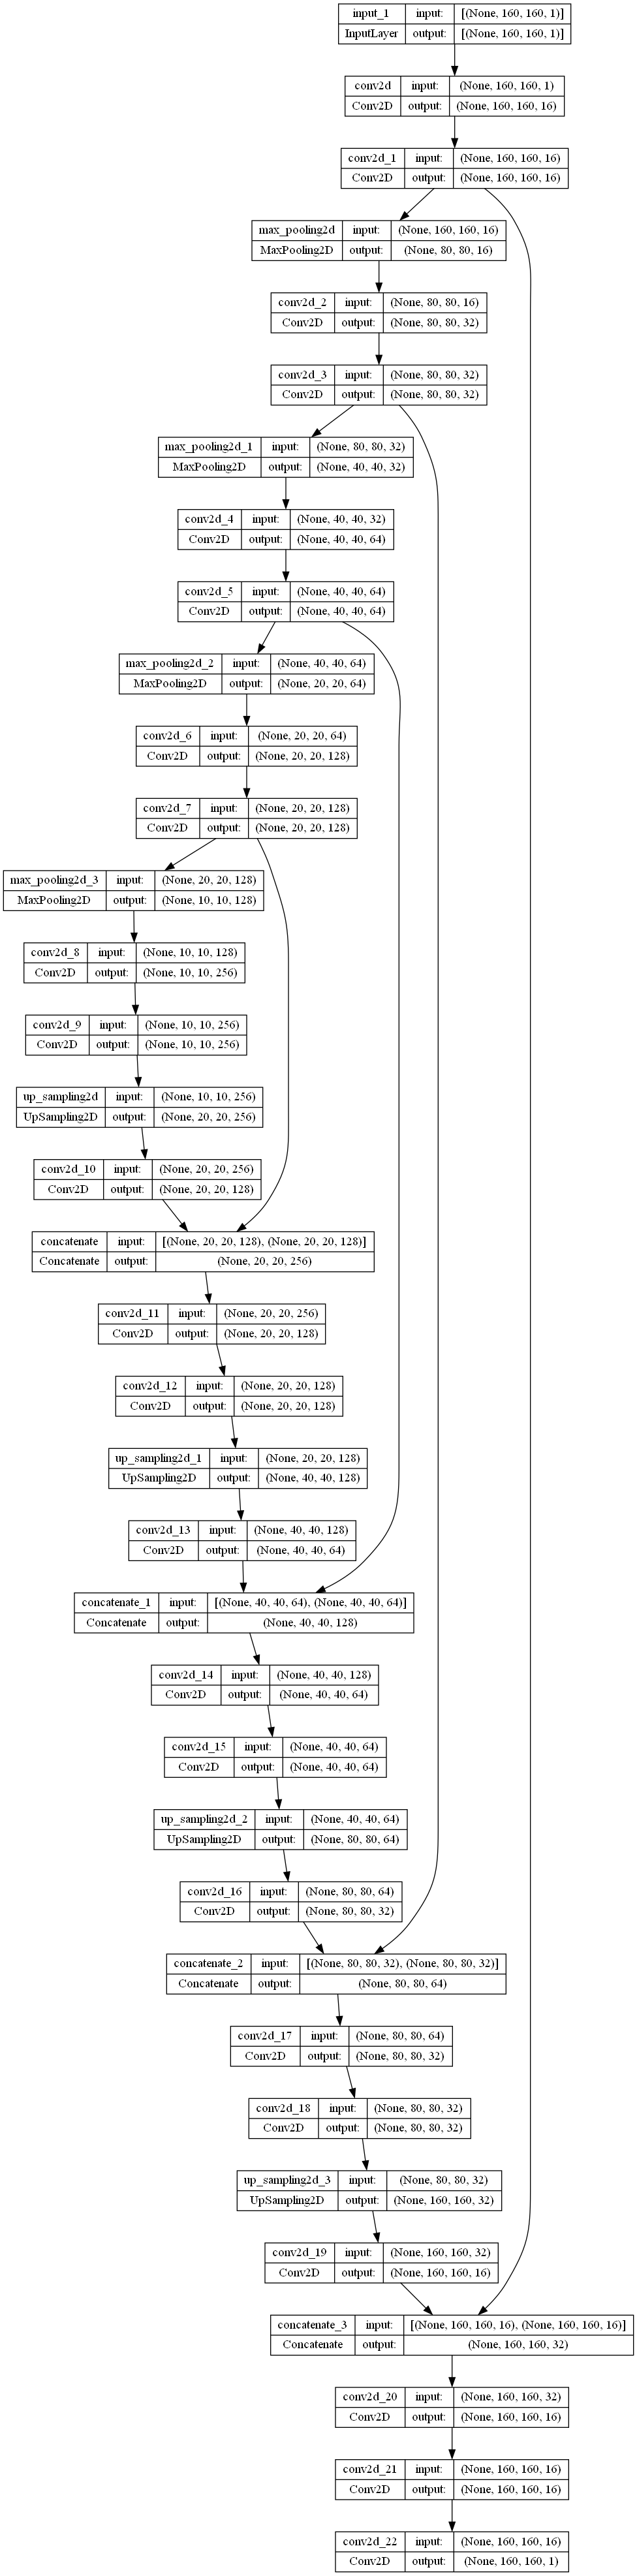

In [11]:

# Compile the model
optimizer = keras.optimizers.Adam()
loss = ['binary_crossentropy',dice_loss]
metrics = ['binary_accuracy',dice_metric]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics) 

# What does the finished model look like?
model.summary()
keras.utils.plot_model(model, show_shapes=True, rankdir='TD')

## Fit the model

The fit() function takes x and y -- we want to pass the image and mask  correspondingly.

But since we are using generators, we need the output of the generator to be: `(image, mask)`

We can create this behaviour by using `zip()` to zip together the image and mask generators. 




In [12]:
# combine generators into one which yields both image and masks
train_generator = zip(image_generator_train, mask2_generator_train)
test_generator = zip(image_generator_test, mask2_generator_test)

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10)


Epoch 1/10
100/100 [==============================] - 13s 123ms/step - loss: 0.0974 - binary_accuracy: 0.9870 - dice_metric: 0.0259
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0211 - binary_accuracy: 0.9906 - dice_metric: 0.0671
Epoch 3/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0198 - binary_accuracy: 0.9903 - dice_metric: 0.0863
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0175 - binary_accuracy: 0.9911 - dice_metric: 0.0918
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0164 - binary_accuracy: 0.9899 - dice_metric: 0.1874
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0112 - binary_accuracy: 0.9906 - dice_metric: 0.3122
Epoch 7/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0103 - binary_accuracy: 0.9903 - dice_metric: 0.3841
Epoch 8/10
100/100 [==============================] - 11s 109ms/step - loss:

Plot the loss and metrics on training data

<AxesSubplot: >

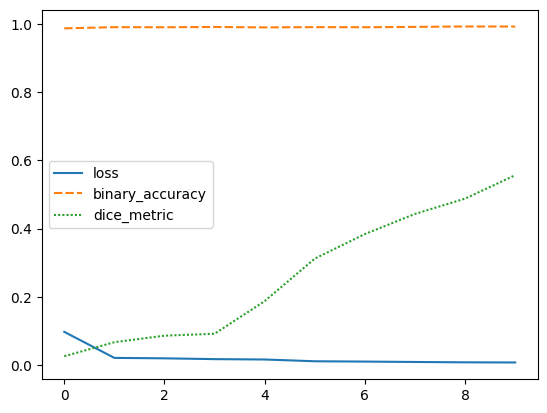

In [13]:
#plot loss and metrics
import pandas as pd
import seaborn as sns
df = pd.DataFrame(history.history)
sns.lineplot(data=df)


Evaluate the metrics on the test data

In [14]:
metrics = model.evaluate(test_generator,steps=197,return_dict=True)
print(metrics)

197/197 [==============================] - 6s 29ms/step - loss: 0.0062 - binary_accuracy: 0.9975 - dice_metric: 0.6537
{'loss': 0.006224128417670727, 'binary_accuracy': 0.997543454170227, 'dice_metric': 0.6536521315574646}


Let's take a look at some results for the test dataset

1/1 [==============================] - 0s 43ms/step


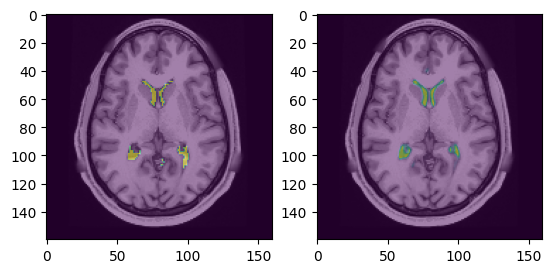

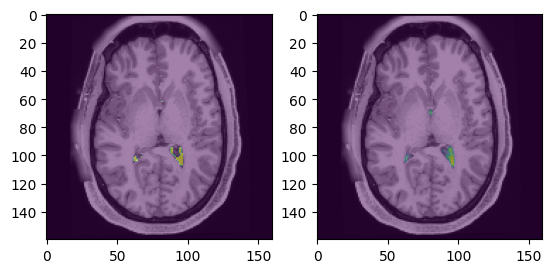

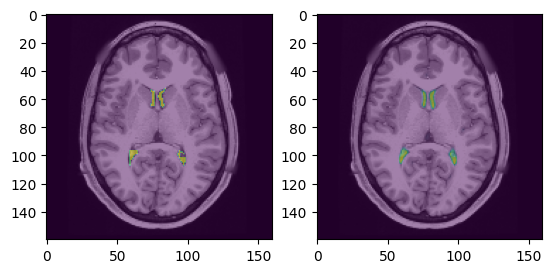

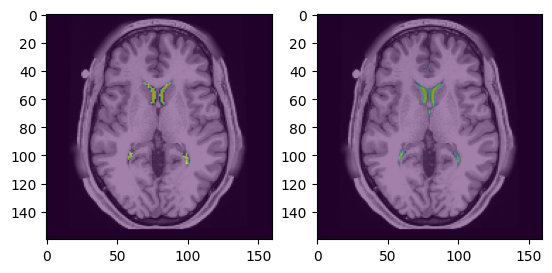

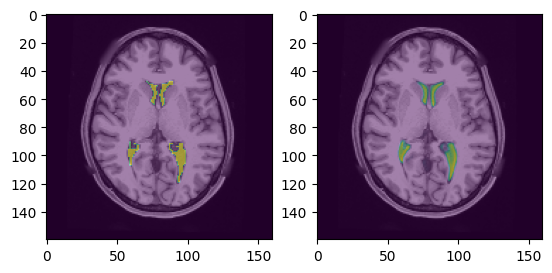

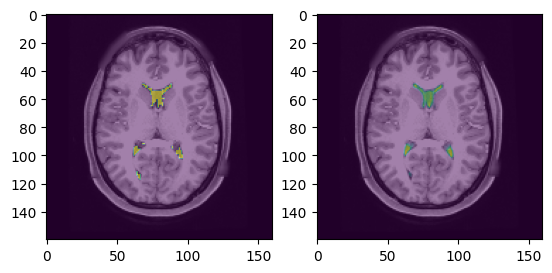

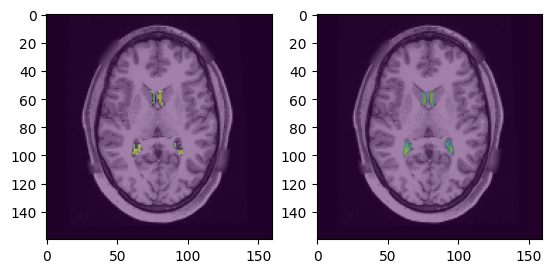

In [15]:
#plot some examples from the test set

for sample,(image,mask) in enumerate(test_generator):
  
  predicted = model.predict(image)

  plt.figure()

  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(mask),alpha=0.5)
  
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(image),cmap='gray')
  plt.imshow(np.squeeze(predicted),alpha=0.5)
  

  if sample > 5:
    break
  

## Beyond this example

### More than just binary labels?

We took a shortcut here and used a single channel output and sigmoid to get our label. More generally if you have multiple labels, you will want to use a *one-hot* encoding analogous to what we did for multi-class classification, and use a soft-max activation.

 E.g. if we wanted to have our example data (brain and ventricle segmentation) set up in this way, we would need to have the following 3 channels:
 - background: 1 where neither brain nor ventricles are, 0 elsewhere
 - brain: 1 where brain is, 0 elsewhere (we have this already)
 - ventricles: 1 where ventricles are, 0 elsewhere (we have this already)

So in this case you would need to create the background channel, e.g. via logical operations on the other channels. 

If you are starting with a single image with multiple labels on it, then you should be able to use Keras' built-in `to_categorical()` to achieve this.

Note that if you have multiple labels, you would also need to account for this in any custom loss functions you create.

### Validation split?
We didn't use a validation split here for the sake of simplicity. You can achieve this by either putting your validation data in another directory and creating another `flow` generator, **or** you can use `validation_split` in the ImageDataGenerator, then specify `subset='validation'` or `subset='training'` in your `flow` generator to make use of the reserved split. 

In both cases you would need to then pass the validation generator to the `fit()` functions `validation_data` parameter. 
